In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_theme(style='white', context='notebook', font_scale=1.33)

## Section 1: Demographics

In [2]:
## Load data.
covariates = read_csv(os.path.join('data', 'covariates.csv'))

## Apply screening.
covariates = covariates.query('infreq <= 0.5')

#### 1.1 Gender composition

In [3]:
from statsmodels.stats.proportion import proportions_ztest

## Print gender composition.
print(covariates.groupby('study').gender.value_counts(), end='\n\n')

## Perform proportion test.
stat, pval = proportions_ztest([670, 310], [1051, 582])
print('proportions test: z = %0.3f (p = %0.3f)' %(stat, pval))

study         gender        
teicher2015   Female            670
              Male              381
tuominen2022  Female            310
              Male              258
              Other               9
              Rather not say      5
Name: gender, dtype: int64

proportions test: z = 4.142 (p = 0.000)


#### 1.2 Age composition

In [4]:
from scipy.stats import ttest_ind

## Print age composition.
print(covariates.groupby('study').age.describe().round(2), end='\n\n')

## Perform independent t-test.
stat, pval = ttest_ind(covariates.query('study == "teicher2015"').age,
                       covariates.query('study == "tuominen2022"').age)
print('independent t-test: t = %0.3f (p = %0.3f)' %(stat, pval))

               count   mean    std   min    25%    50%    75%    max
study                                                               
teicher2015   1051.0  23.11   1.66  18.2  21.82  23.15  24.46  27.15
tuominen2022   582.0  30.23  11.73  18.0  22.00  26.50  35.75  80.00

independent t-test: t = -19.313 (p = 0.000)


#### 1.3 Ethnic composition

In [5]:
from statsmodels.stats.proportion import proportions_ztest

## Print gender composition.
print(covariates.groupby('study').ethnicity.value_counts(), end='\n\n')

## Perform proportion test.
stat, pval = proportions_ztest([84, 57], [1051, 582])
print('proportions test: z = %0.3f (p = %0.3f)' %(stat, pval))

study         ethnicity             
teicher2015   Not Hispanic or Latino    963
              Hispanic or Latino         84
tuominen2022  Not Hispanic or Latino    518
              Hispanic or Latino         57
              Rather not say              7
Name: ethnicity, dtype: int64

proportions test: z = -1.241 (p = 0.214)


#### 1.4 Racial composition

In [6]:
from statsmodels.stats.proportion import proportions_ztest

## Print gender composition.
print(covariates.groupby('study').race.value_counts(), end='\n\n')

## Perform proportion test.
stat, pval = proportions_ztest([806, 441], [1051, 582])
print('proportions test: z = %0.3f (p = %0.3f)' %(stat, pval))

study         race                         
teicher2015   White                            806
              Asian                            103
              Black or African American         81
              Other                             47
              American Indian/Alaska Native     14
tuominen2022  White                            441
              Asian                             65
              Black or African American         31
              Multiracial                       26
              Rather not say                    17
              American Indian/Alaska Native      2
Name: race, dtype: int64

proportions test: z = 0.417 (p = 0.677)


## Section 2: Item Endorsement

In [7]:
## Load data.
mace = read_csv(os.path.join('data', 'mace.csv'))

## Apply screening.
mace = mace[mace.subject.isin(covariates.query('infreq <= 0.5').subject)]

#### 2.1 Item-level comparison

spearman correlation: rho = 0.947



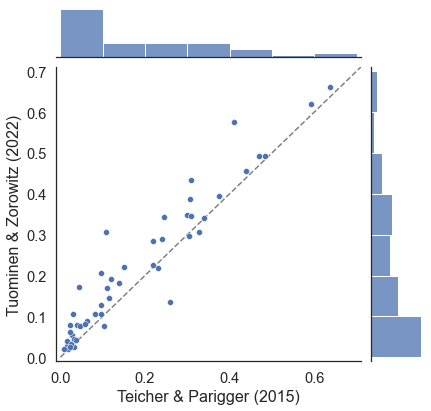

In [8]:
## Compute endorsement rate by study / item. 
pivot = mace.pivot_table('response','item','study')

## Perform Spearman rank correlation.
stat = pivot.corr(method='spearman').values[0,1]
print('spearman correlation: rho = %0.3f' %stat, end='\n\n')

## Initialize canvas.
g = sns.JointGrid(data=pivot, xlim=(-0.01, 0.71), ylim=(-0.01, 0.71))

## Plot endorsement distributions.
sns.histplot(x='teicher2015', data=pivot, bins=np.arange(0.0,0.8,0.1), ax=g.ax_marg_x)
sns.histplot(y='tuominen2022', data=pivot, bins=np.arange(0.0,0.8,0.1), ax=g.ax_marg_y)

## Plot endorsement correlation.
sns.scatterplot(x='teicher2015', y='tuominen2022', data=pivot, ax=g.ax_joint)
g.ax_joint.plot([0,1], [0,1], color='0.5', linestyle='--', zorder=-1)
g.ax_joint.set(xlabel='Teicher & Parigger (2015)', ylabel='Tuominen & Zorowitz (2022)');

#### 2.2 Person-level comparison

independent t-test: t = -5.848 (p = 0.000)



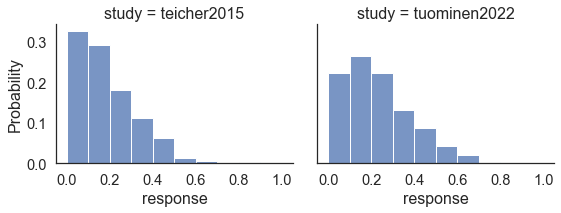

In [9]:
## Compute endorsement rate by participant. 
gb = mace.groupby(['study','subject']).response.mean().reset_index()

## Perform independent t-test.
stat, pval = ttest_ind(gb.query('study == "teicher2015"').response,
                       gb.query('study == "tuominen2022"').response)
print('independent t-test: t = %0.3f (p = %0.3f)' %(stat, pval), end='\n\n')

## Initialize canvas.
g = sns.FacetGrid(data=gb, col='study', height=3.25, aspect=1.25)

## Plot score distributions.
g.map(sns.histplot, 'response', bins=np.linspace(0,1,11), stat='probability')
g.set(xticks=np.arange(0,1.1,0.2));

#### 2.3 Differential item functioning

In [10]:
from pandas import DataFrame, concat
from statsmodels.api import Logit

## Compute observed & rest scores.
zscore = lambda x: (x - np.nanmean(x)) / np.nanstd(x)
mace['score'] = mace.groupby('subject').response.transform(np.nansum)
mace['rest'] = mace['score'] - mace['response'] 
mace['rest'] = zscore(mace.rest)

## Dummy-code group variables.
mace = mace.merge(covariates[['subject','gender','age']], on='subject')
mace['gender'] = mace.gender.replace({'Male': -0.5, 'Female': 0.5, 'Other': 0, 'Rather not say': 0})
mace['study'] = mace.study.replace({'teicher2015':-0.5, 'tuominen2022': 0.5})
mace['age'] = zscore(mace.age)

In [11]:

## Define formula.
formula = 'response ~ rest + study + gender + age'

## Preallocate space.
dif = []

## Iterate over items.
for item in mace.item.unique():
        
    ## Restrict DataFrame.
    df = mace.query(f'item == {item}')
    df = df[df.response.notnull()]
    
    ## Fit logistic regression model.
    fit = Logit.from_formula(formula, data=df).fit(disp=0)
    
    ## Check convergence.
    if not fit.mle_retvals['converged']: 
        print(item)
        continue
        
    ## Convert to DataFrame.
    df = DataFrame([fit.params, fit.tvalues, fit.pvalues], index=['coef','tval','pval']).T
    df = df.reset_index().rename(columns={'index':'variable'}).round(6)
    df.insert(0, 'item', item)
    
    ## Append.
    dif.append(df)
    
## Concatenate DataFrames.
dif = concat(dif).query('variable != "Intercept"').reset_index(drop=True)

In [12]:
coef = dif.pivot_table('coef', 'item', 'variable')
pval = dif.pivot_table('pval', 'item', 'variable')
large = np.logical_and(np.abs(2.35 * coef) > 1.5, pval < 0.05).astype(int)
med = np.logical_and(np.abs(2.35 * coef) > 1, pval < 0.05).astype(int) - large

In [13]:
large.sum()

variable
age        0
gender    11
rest      52
study     11
dtype: int64